In [164]:
import casadi as csd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [165]:
s = np.array([[-1.0, -1.0, 1.0, 0.0],
              [0.0, -1.0, -1.0, 1.0]
             ])

In [166]:
def rxnfn(kf, tf, s):
    
    nr, nc = s.shape
    
    c = csd.SX.sym('c', nc)
    
    r = []
    for i in range(nr):
        ri = kf[i]
        for j in range(nc):
            if s[i, j] < 0:
                ri = ri * c[j] ** (-s[i, j])
        r.append(ri) 
        
    dc = []
    for i in range(nc):
        dci = 0
        for j in range(nr):
            dci = dci + s[j, i] * r[j]
        dc.append(dci)
        
    ode = {}
    ode['x'] = c
    ode['p'] = kf
    ode['ode'] = csd.vertcat(*dc)
    
    F = csd.integrator('F','cvodes',ode,{'tf':tf})
    
    return F

In [168]:
tmp = rxnfn(kf = csd.SX.sym('kf', 2), tf = 4, s = s)
res = tmp(x0 = [1, 1, 0, 0], p = [1, 2])
res['xf']

DM([0.391509, 0.0212474, 0.238229, 0.370262])

In [169]:
t = np.linspace(0, 10)
dt = t[1:] - t[:-1]

In [170]:
c0 = [1.0, 2.0, 0.0, 0.0]
kf = [1, 0.2]
xf_list = np.zeros((len(t), 4))
xf_list[0] = np.array(c0)
for i in range(len(dt)):
    #print(i)
    F = rxnfn(kf = csd.SX.sym('kf', 2), tf = dt[i], s = s)
    res = F(x0 = c0, p = kf)
    xf_list[i + 1,:] = res['xf'].full().T
    c0 = res['xf']

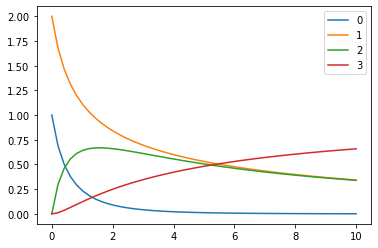

In [171]:
fig, ax = plt.subplots()
for i in range(nc):
    ax.plot(t, xf_list[:, i], label = i)
ax.legend()

In [172]:
# Generate dummy data
data = xf_list[1:,:] + np.random.normal(0, 0.2, (49, 4))

In [173]:
data = np.concatenate((t[1:,np.newaxis], data), axis = 1)

In [174]:
data_df = pd.DataFrame(data, columns = ['t', 'ca', 'cb', 'cc', 'cd'])

In [175]:
data_df.to_csv('ABCD_data.csv', index = False)